In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import voxart

# Original viz development

Ideas for visualizaitons

* Preprocessing
   * Add overall rank by objective_value
   * Add order processed index (based on batch_idx, form_idx, filled_iteration, conn_iteration, idx_in_bottom_location
* To look at overall distributions of objective values
   * For filled only and complete, ecdfs + histograms of objective values
   * distribution of the numbers of ties
* To look at form indices
   * Among best N, what is the distribution of filled_form_idx
   * For each filled_form_idx, what's the distribution of scores
* To see if we need more iterations in filled searching
   * Number of unique/not-unique as a function of batch_idx,filled_iteration
* To see if we need more batches
   * Number of filled_is_unique per batch (or maybe as a fraction?). Need to reduce to batch_idx, idx_in_batch
* To see how being good in a batch is related to being good at the end (may affect hwo deep to go in batches)
   * scatter plot of the idx_in_batch and the final rank
      * maybe restrict to idx_in_bottom_location == 0
* To see if we are trying enough random iterations for connectors
   * Number unique/not-unique for each conn_iteration
      * Maybe restrict to idx_in_bottom_location == 0
   * Scatter plot of conn_iterations and rank / objective_value
* Big picture progress
   * objective_value vs. order processed (along with a min)

In [159]:
df_results.sample(3)

,batch_idx,idx_in_batch,filled_form_idx,filled_is_starting,filled_iteration,filled_is_unique,filled_uid,idx_in_connector,conn_iteration,conn_num_connectors,idx_in_bottom_location,bottom_location,is_unique,uid,objective_value,objective_value_rank
290,0,1,2,False,1,True,1,16,31,5,2,"(1, 0, 0)",True,234,28.2,62
934,0,8,38,False,0,True,5,16,16,6,6,"(0, 1, 1)",True,822,33.0,796
145,0,0,3,False,1,True,0,18,10,7,1,"(0, 1, 1)",True,113,30.2,306


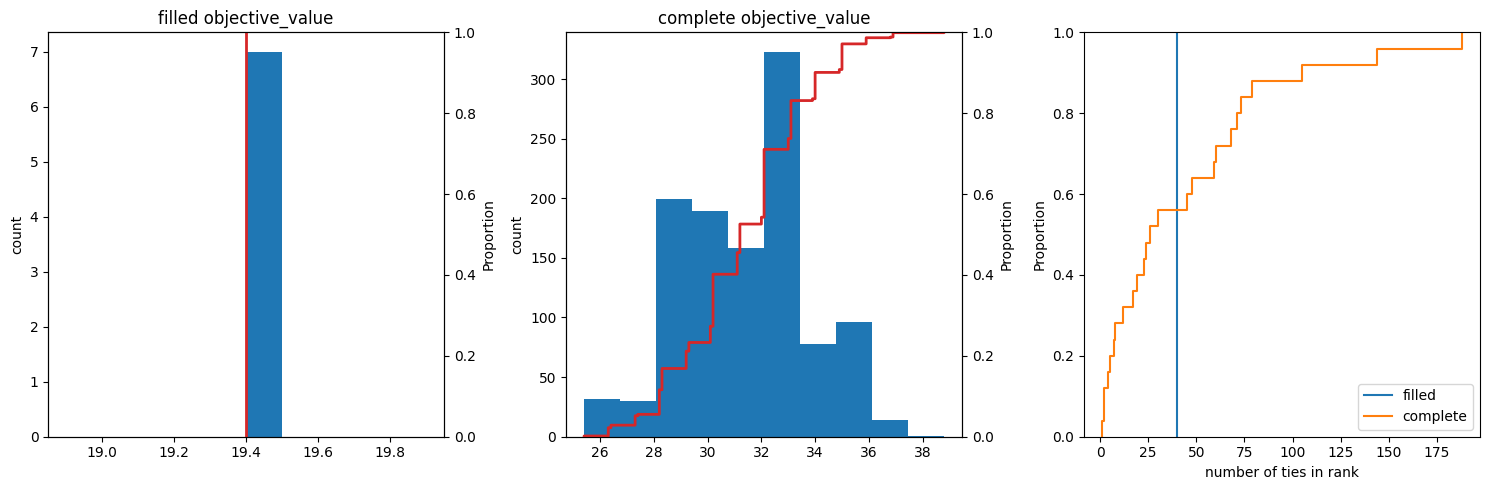

In [195]:
def _ecdf_plus_hist(ax, vals, color):
    ax.hist(vals, color="tab:blue")
    ax.set_ylabel("count")
    ax2 = ax.twinx()
    sns.ecdfplot(ax=ax2, data=vals, color="tab:red", lw=2)

def _ties_plot(ax, vals, label):
    #data = vals.value_counts().value_counts()
    #ax.bar(data.index, data, label=label)
    sns.ecdfplot(ax=ax, data=vals.value_counts(), label=label)
    ax.set_xlabel("number of ties in rank")
    
def objective_distributions_plot(df_filled_results, df_results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    ax = axes[0]
    _ecdf_plus_hist(ax, df_filled_results.loc[df_filled_results["filled_is_unique"], "objective_value"],
                  color="b")
    ax.set_title("filled objective_value")

    ax = axes[1]
    _ecdf_plus_hist(ax, df_results["objective_value"],
                  color="g")
    ax.set_title("complete objective_value")
    
    ax = axes[2]
    _ties_plot(ax, df_filled_results["objective_value_rank"], label="filled")
    _ties_plot(ax, df_results["objective_value_rank"], label="complete")
    ax.legend()
    
    fig.tight_layout()
    plt.close()
    return fig

objective_distributions_plot(df_filled_results, df_results)

In [ ]:
df_results["objective_value_rank"].value_counts().sort_index()

In [189]:
df_results["objective_value_rank"].value_counts().value_counts().sort_index()

1      1
2      2
4      1
5      1
7      1
8      1
12     1
17     1
19     1
23     1
24     1
26     1
30     1
45     1
48     1
59     1
60     1
68     1
71     1
73     1
79     1
105    1
144    1
188    1
Name: objective_value_rank, dtype: int64

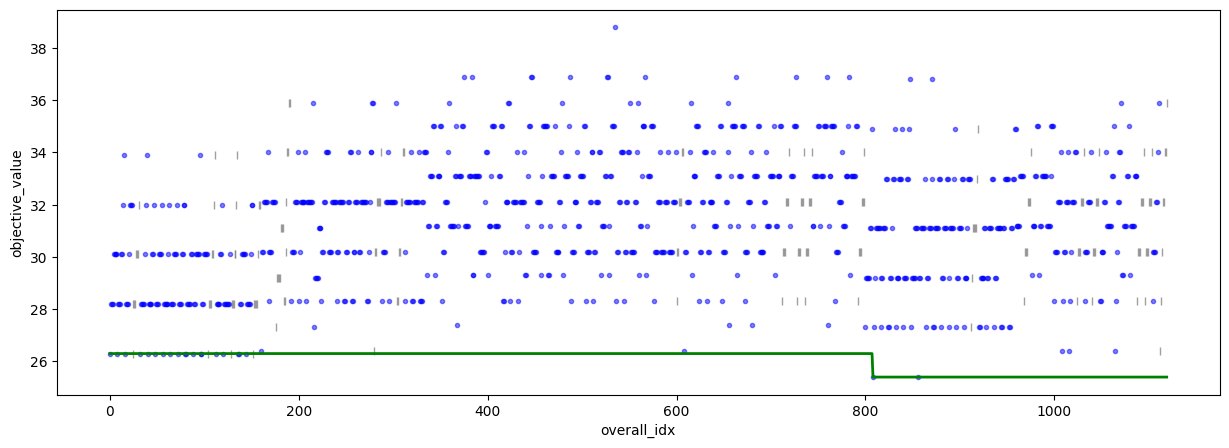

In [160]:
def overall_progress_plot(df_results):
    df_results = results.all_objective_values().sort_values(["batch_idx", "filled_form_idx", "filled_iteration", "conn_iteration", "idx_in_bottom_location"])
    df_results["idx_overall"] = np.arange(len(df_results))

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    df = df_results[~df_results["is_unique"]]
    ax.plot(df["idx_overall"], df["objective_value"], color="gray", linestyle="", marker="|", alpha=0.75)
    df = df_results[df_results["is_unique"]]
    ax.plot(df["idx_overall"], df["objective_value"], color="b", linestyle="", marker=".", alpha=0.5)
    ax.plot(df_results["idx_overall"], df_results["objective_value"].cummin(), color="g", marker="", lw=2)
    ax.set_xlabel("overall_idx")
    ax.set_ylabel("objective_value")
    plt.close()
    return fig
overall_progress_plot(df_results)

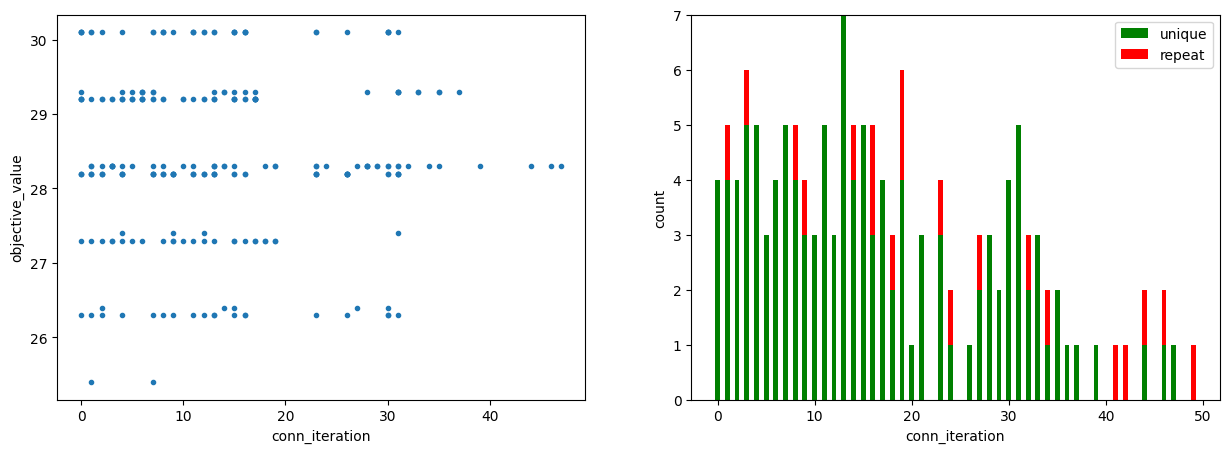

In [161]:
def connector_iterations_plot(df_results):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Show only the top 25% of ranks
    rank_limit = df_results["objective_value_rank"].max() // 4
    df = df_results[df_results["is_unique"] & (df_results["objective_value_rank"] <= rank_limit)]
    axes[0].scatter(df["conn_iteration"], df["objective_value"], marker=".")
    axes[0].set_xlabel("conn_iteration")
    axes[0].set_ylabel("objective_value")
    
    df_summ = (df_results[df_results["idx_in_bottom_location"] == 0]
               .groupby("conn_iteration")
          ["is_unique"]
          .apply(lambda s: pd.Series(index=pd.Index(name="tmp_is_unique", data=[True, False]),
                                     data=(np.sum(s == True), np.sum(s == False))))
          .reset_index()
          .rename(columns={"is_unique": "count", "tmp_is_unique": "is_unique"})
         )
    df = df_summ[df_summ["is_unique"] == True]
    axes[1].bar(df["conn_iteration"], df["count"], 0.5, label="unique", color="green")
    bottom = df["count"]
    df = df_summ[df_summ["is_unique"] == False]
    axes[1].bar(df["conn_iteration"], df["count"], 0.5, label="repeat", color="red", bottom=bottom)
    axes[1].legend()
    axes[1].set_xlabel("conn_iteration")
    axes[1].set_ylabel("count")
    plt.close()
    return fig
connector_iterations_plot(df_results)

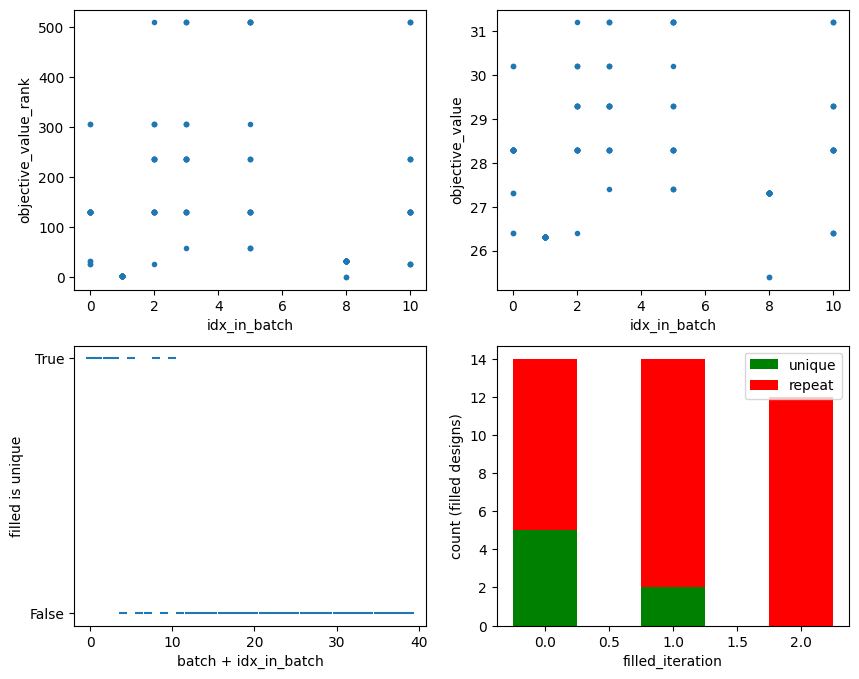

In [162]:
# To see how being good in a batch is related to being good at the end (may affect hwo deep to go in batches)
#scatter plot of the idx_in_batch and the final rank
#maybe restrict to idx_in_bottom_location == 0
#Number of filled_is_unique per batch (or maybe as a fraction?). Need to reduce to batch_idx, idx_in_batch
def batch_plot(df_filled_results, df_results):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    df = df_results[df_results["idx_in_bottom_location"] == 0]
    ax = axes[0, 0]
    ax.scatter(df["idx_in_batch"], df["objective_value_rank"], marker=".")
    ax.set_xlabel("idx_in_batch")
    ax.set_ylabel("objective_value_rank")

    ax = axes[0, 1]
    ax.scatter(df["idx_in_batch"], df["objective_value"], marker=".")
    ax.set_xlabel("idx_in_batch")
    ax.set_ylabel("objective_value")

    ax = axes[1, 0]
    batch_size = df_filled_results["idx_in_batch"].max() + 1
    df_filled_results["idx"] = df_filled_results["batch_idx"] * batch_size + df_filled_results["idx_in_batch"]

    ax.scatter(df_filled_results["idx"], df_filled_results["filled_is_unique"], marker="_")
    for batch in range(0, df["batch_idx"].max()):
        ax.axvline((batch + 1) * batch_size, color="gray", zorder=0)
    ax.set_xlabel("batch + idx_in_batch")
    ax.set_ylabel("filled is unique")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["False", "True"])
    
    ax = axes[1, 1]
    df_summ = (df_filled_results
               .groupby("filled_iteration")
          ["filled_is_unique"]
          .apply(lambda s: pd.Series(index=pd.Index(name="tmp_filled_is_unique", data=[True, False]),
                                     data=(np.sum(s == True), np.sum(s == False))))
          .reset_index()
          .rename(columns={"filled_is_unique": "count", "tmp_filled_is_unique": "filled_is_unique"})
         )
    df = df_summ[df_summ["filled_is_unique"] == True]
    ax.bar(df["filled_iteration"], df["count"], 0.5, label="unique", color="green")
    bottom = df["count"]
    df = df_summ[df_summ["filled_is_unique"] == False]
    ax.bar(df["filled_iteration"], df["count"], 0.5, label="repeat", color="red", bottom=bottom)
    ax.legend()
    ax.set_xlabel("filled_iteration")
    ax.set_ylabel("count (filled designs)")

    plt.close()
    return fig
batch_plot(df_filled_results, df_results)

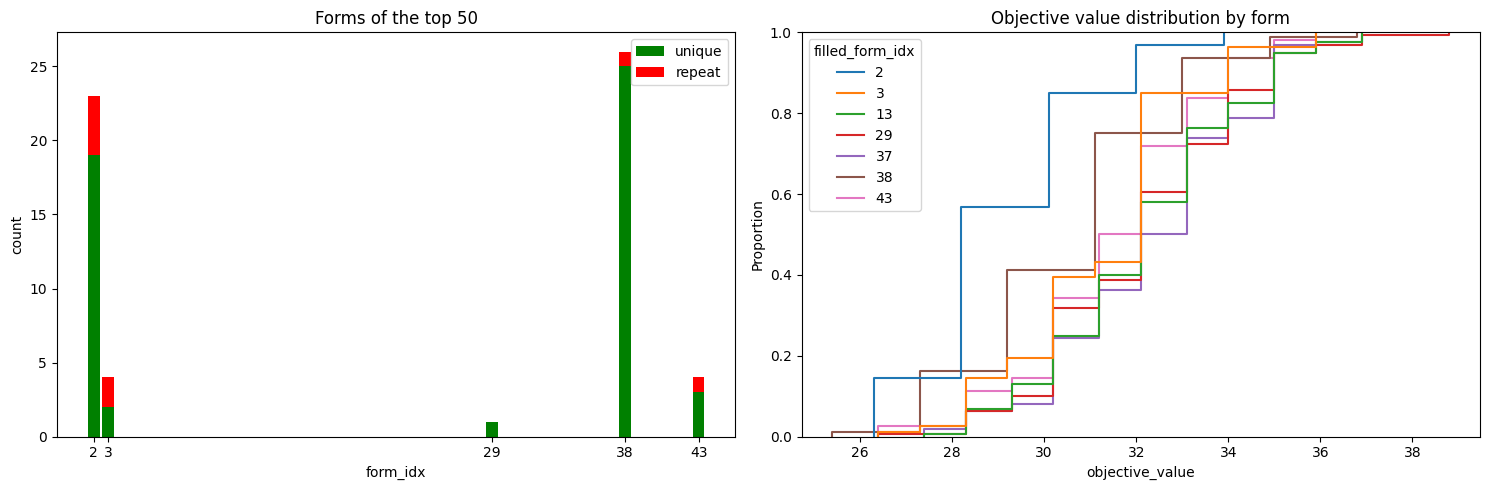

In [215]:
#To look at form indices
#Among best N, what is the distribution of filled_form_idx
#For each filled_form_idx, what's the distribution of scores
def forms_plot(df_results, top_n=50):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    ax = axes[0]
    df_best_forms = df_results[df_results["objective_value_rank"] < top_n]
    best_unique = df_best_forms.loc[df_best_forms["is_unique"], "filled_form_idx"].value_counts().rename("unique")
    best_repeat = df_best_forms.loc[~df_best_forms["is_unique"], "filled_form_idx"].value_counts().rename("repeat")
    df_merged = pd.DataFrame(best_unique).merge(pd.DataFrame(best_repeat), left_index=True, right_index=True, how="outer")
    
    ax.bar(df_merged.index, df_merged["unique"], color="green", label="unique")
    ax.bar(df_merged.index, df_merged["repeat"], bottom=df_merged["unique"], color="red", label="repeat")
    ax.set_xticks(df_merged.index)
    ax.set_xlabel("form_idx")
    ax.set_ylabel("count")
    ax.set_title(f"Forms of the top {top_n}")
    ax.legend()
    
    ax = axes[1]
    sns.ecdfplot(ax=ax, data=df_results, x="objective_value", hue="filled_form_idx", palette="tab10")
    ax.set_title("Objective value distribution by form")
    
    fig.tight_layout()
    plt.close()
    return fig

forms_plot(df_results)

In [37]:
# This was originally drafted by ChatGPT!
def rankdata(a):
    """Assigns rank to data, dealing with ties appropriately."""
    a = np.asarray(a)
    s = np.argsort(a)
    ranks = np.empty_like(s)
    ranks[s] = np.arange(len(a))
    ties = np.flatnonzero(np.diff(a[s]) == 0)
    print(ties)
    if len(ties) == 0:
        return ranks + 1
    else:
        ties += 1
        rt = np.empty_like(ties, dtype=np.float64)
        rt[0] = ranks[s][ties[0] - 1] + 1
        for i in range(1, len(ties)):
            prev_tie = ties[i - 1]
            this_tie = ties[i]
            rt[i] = ranks[s][this_tie - 1] + 1
            if this_tie - prev_tie == 2:
                rt[i - 1] = ranks[s][prev_tie] + 1
            elif this_tie - prev_tie > 2:
                rt[i - 1] = ranks[s][prev_tie] + 1
        rt[-1] = ranks[s][ties[-1]] + 1
        ranks[s[ties]] = rt
        return ranks
    
rankdata([10, 20, 20, 20, 30, 30, 40, 50])

[1 2 4]


array([0, 1, 2, 4, 4, 6, 6, 7])

In [42]:
# My version using some of those ideas
def rankdata2(a):
    """Assigns rank to data, dealing with ties appropriately."""
    a = np.asarray(a)
    s = np.argsort(a)
    ranks = np.empty_like(s)
    ranks[s] = np.arange(len(a))
    ties = np.flatnonzero(np.diff(a[s]) == 0)
    #print(ties)
    for tie_idx in ties:
        ranks[s[tie_idx + 1]] = ranks[s[tie_idx]]
    return ranks
    
display(rankdata2([10, 20, 20, 20, 30, 30, 40, 50]))
display(rankdata2(list(reversed([10, 20, 20, 20, 30, 30, 40, 50]))))

array([0, 1, 1, 1, 4, 4, 6, 7])

array([7, 6, 4, 4, 1, 1, 1, 0])

# revision to handle invalid results

In [63]:
def _ecdf_plus_hist(ax, vals, color):
    ax.hist(vals, color="tab:blue")
    ax.set_ylabel("count")
    ax2 = ax.twinx()
    sns.ecdfplot(ax=ax2, data=vals, color="tab:red", lw=2)


def _ties_plot(ax, vals, label):
    # data = vals.value_counts().value_counts()
    # ax.bar(data.index, data, label=label)
    sns.ecdfplot(ax=ax, data=vals.value_counts(), label=label)
    ax.set_xlabel("number of ties in rank")


def objective_distributions_plot(
    df_filled_results: pd.DataFrame, df_results: pd.DataFrame
) -> plt.Figure:
    """Plots for understanding distribution of objective values.

    Expects dataframes from the results of search(), converted via all_objective_values()
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax = axes[0]
    _ecdf_plus_hist(
        ax,
        df_filled_results.loc[df_filled_results["filled_is_unique"], "objective_value"],
        color="b",
    )
    ax.set_title("filled objective_value")

    ax = axes[1]
    df = df_results[~df_results["conn_failure"]]
    _ecdf_plus_hist(ax, df["objective_value"], color="g")
    ax.text(0.01, 0.99, f"%Success={len(df)/len(df_results)*100:.1f}", ha="left", va="top", transform=ax.transAxes)
    ax.set_title("complete objective_value")

    ax = axes[2]
    _ties_plot(ax, df_filled_results["objective_value_rank"], label="filled")
    _ties_plot(ax, df_results.loc[~df_results["conn_failure"], "objective_value_rank"], label="complete")
    ax.legend()

    fig.tight_layout()
    plt.close()
    return fig


def overall_progress_plot(
        df_filled_results: pd.DataFrame, df_results: pd.DataFrame):
    """Shows how the objective value evolves over the search.

    Unique results are blue circles
    Non-uique are gray vertical lines
    Green line shows progress of best so far.
    """
    df_results = df_results.sort_values(
        [
            "batch_idx",
            "filled_form_idx",
            "filled_iteration",
            "conn_iteration",
            "idx_in_bottom_location",
        ]
    )
    df_results["idx_overall"] = np.arange(len(df_results))
    df_filtered = df_results[~df_results["conn_failure"]]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    df = df_filtered[~df_filtered["is_unique"]]
    ax.plot(
        df["idx_overall"],
        df["objective_value"],
        color="gray",
        linestyle="",
        marker="|",
        alpha=0.75,
    )
    df = df_filtered[df_filtered["is_unique"]]
    ax.plot(
        df["idx_overall"],
        df["objective_value"],
        color="b",
        linestyle="",
        marker=".",
        alpha=0.5,
    )
    ax.plot(
        df_filtered["idx_overall"],
        df_filtered["objective_value"].cummin(),
        color="g",
        marker="",
        lw=2,
    )
    ax.set_xlim(0)
    ax.set_xlabel("overall_idx")
    ax.set_ylabel("objective_value")
    plt.close()
    return fig


def connector_iterations_plot(
        df_filled_results: pd.DataFrame, df_results: pd.DataFrame):
    """Helps to understand if the connector search iterations are sufficient."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Show only the top 25% of ranks
    rank_limit = df_results["objective_value_rank"].max() // 4
    df = df_results[
        df_results["is_unique"] & (df_results["objective_value_rank"] <= rank_limit) & ~df_results["conn_failure"]
    ]
    axes[0].scatter(df["conn_iteration"], df["objective_value"], marker=".")
    axes[0].set_xlabel("conn_iteration")
    axes[0].set_ylabel("objective_value")

    df_summ = (
        df_results[(df_results["idx_in_bottom_location"] == 0) & ~df_results["conn_failure"]]
        .groupby("conn_iteration")["is_unique"]
        .apply(
            lambda s: pd.Series(
                index=pd.Index(name="tmp_is_unique", data=[True, False]),
                data=(np.sum(s == True), np.sum(s == False)),
            )
        )
        .reset_index()
        .rename(columns={"is_unique": "count", "tmp_is_unique": "is_unique"})
    )
    df = df_summ[df_summ["is_unique"] == True]
    axes[1].bar(df["conn_iteration"], df["count"], 0.5, label="unique", color="green")
    bottom = df["count"]
    df = df_summ[df_summ["is_unique"] == False]
    axes[1].bar(
        df["conn_iteration"],
        df["count"],
        0.5,
        label="repeat",
        color="red",
        bottom=bottom,
    )
    axes[1].legend()
    axes[1].set_xlabel("conn_iteration")
    axes[1].set_ylabel("count")
    plt.close()
    
    df_failure_rate = (
        df_results[df_results["idx_in_bottom_location"] == 0]
        .groupby("conn_iteration")["conn_failure"]
        .mean()
        .reset_index()
    )
    axes[2].plot(df_failure_rate["conn_iteration"], df_failure_rate["conn_failure"], lw=2, marker="o")
    axes[2].set_xlabel("conn_iteration")
    axes[2].set_ylabel("failure_rate")
    return fig


def batch_plot(df_filled_results: pd.DataFrame, df_results: pd.DataFrame):
    """Helps to understand if the batches and sizes are sufficient."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    df = df_results[(df_results["idx_in_bottom_location"] == 0) & ~df_results["conn_failure"]]
    ax = axes[0, 0]
    ax.scatter(df["idx_in_batch"], df["objective_value_rank"], marker=".")
    ax.set_xlabel("idx_in_batch")
    ax.set_ylabel("objective_value_rank")

    ax = axes[0, 1]
    ax.scatter(df["idx_in_batch"], df["objective_value"], marker=".")
    ax.set_xlabel("idx_in_batch")
    ax.set_ylabel("objective_value")

    ax = axes[1, 0]
    batch_size = df_filled_results["idx_in_batch"].max() + 1
    df_filled_results["idx"] = (
        df_filled_results["batch_idx"] * batch_size + df_filled_results["idx_in_batch"]
    )

    ax.scatter(
        df_filled_results["idx"], df_filled_results["filled_is_unique"], marker="_"
    )
    for batch in range(0, df["batch_idx"].max()):
        ax.axvline((batch + 1) * batch_size, color="gray", zorder=0)
    ax.set_xlabel("batch + idx_in_batch")
    ax.set_ylabel("filled is unique")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["False", "True"])

    ax = axes[1, 1]
    df_summ = (
        df_filled_results.groupby("filled_iteration")["filled_is_unique"]
        .apply(
            lambda s: pd.Series(
                index=pd.Index(name="tmp_filled_is_unique", data=[True, False]),
                data=(np.sum(s == True), np.sum(s == False)),
            )
        )
        .reset_index()
        .rename(
            columns={
                "filled_is_unique": "count",
                "tmp_filled_is_unique": "filled_is_unique",
            }
        )
    )
    df = df_summ[df_summ["filled_is_unique"] == True]
    ax.bar(df["filled_iteration"], df["count"], 0.5, label="unique", color="green")
    bottom = df["count"]
    df = df_summ[df_summ["filled_is_unique"] == False]
    ax.bar(
        df["filled_iteration"],
        df["count"],
        0.5,
        label="repeat",
        color="red",
        bottom=bottom,
    )
    ax.legend()
    ax.set_xlabel("filled_iteration")
    ax.set_ylabel("count (filled designs)")

    plt.close()
    return fig


def forms_plot(    df_filled_results: pd.DataFrame, df_results: pd.DataFrame, top_n: int = 50):
    """Shows what forms achieve good objective values"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    ax = axes[0, 0]
    df_best_forms = df_results[(df_results["objective_value_rank"] < top_n) & ~df_results["conn_failure"]]
    best_unique = (
        df_best_forms.loc[df_best_forms["is_unique"], "filled_form_idx"]
        .value_counts()
        .rename("unique")
    )
    best_repeat = (
        df_best_forms.loc[~df_best_forms["is_unique"], "filled_form_idx"]
        .value_counts()
        .rename("repeat")
    )
    df_merged = pd.DataFrame(best_unique).merge(
        pd.DataFrame(best_repeat), left_index=True, right_index=True, how="outer"
    )
    df_merged.fillna(0, inplace=True)

    ax.bar(df_merged.index, df_merged["unique"], color="green", label="unique")
    ax.bar(
        df_merged.index,
        df_merged["repeat"],
        bottom=df_merged["unique"],
        color="red",
        label="repeat",
    )
    ax.set_xticks(df_merged.index)
    ax.set_xlabel("form_idx")
    ax.set_ylabel("count")
    ax.set_title(f"Forms of the top {top_n}")
    ax.legend()

    ax = axes[0, 1]
    sns.ecdfplot(
        ax=ax,
        data=df_results[~df_results["conn_failure"]],
        x="objective_value",
        hue="filled_form_idx",
        palette="tab10",
    )
    ax.set_title("Objective value distribution by form")

    ax = axes[1, 0]
    forms_success = (
        df_results.loc[~df_results["conn_failure"], "filled_form_idx"]
        .value_counts()
        .rename("success")
    )
    forms_failure = (
        df_results.loc[df_results["conn_failure"], "filled_form_idx"]
        .value_counts()
        .rename("failure")
    )    
    df = pd.DataFrame(forms_success).merge(
        pd.DataFrame(forms_failure), left_index=True, right_index=True, how="outer"
    )
    df.fillna(0, inplace=True)
    
    ax.bar(df.index, df["success"], color="m", label="success")
    ax.bar(
        df.index,
        df["failure"],
        bottom=df["success"],
        color="y",
        label="failure",
    )
    ax.set_xticks(df.index)
    ax.set_xlabel("form_idx")
    ax.set_ylabel("count")
    ax.set_title("Success/Failure by form")
    ax.legend()
    
    axes[1, 1].axis("off")

    fig.tight_layout()
    plt.close()
    return fig


In [5]:
df_results = pd.read_csv("/Users/priley/Downloads/df_results.csv")
df_filled_results = pd.read_csv("/Users/priley/Downloads/df_filled_results.csv")

In [13]:
df_results.sample(3)

,Unnamed: 0,batch_idx,idx_in_batch,filled_form_idx,filled_is_starting,filled_iteration,filled_is_unique,filled_uid,idx_in_connector,conn_iteration,conn_num_connectors,conn_failure,idx_in_bottom_location,bottom_location,is_unique,uid,objective_value,objective_value_rank
176,176,1,2,6,False,0,True,5,2,2,20,True,0,"(0, 1, 0)",True,168,10127.3,67
135,135,1,1,0,False,0,True,4,0,5,36,False,7,"(0, 0, 0)",True,135,154.7,21
37,37,0,1,34,False,0,True,1,0,1,21,True,5,"(1, 1, 0)",True,37,10132.1,125


In [14]:
df_filled_results.sample(3)

,Unnamed: 0,batch_idx,idx_in_batch,filled_form_idx,filled_is_starting,filled_iteration,filled_is_unique,filled_uid,objective_value,objective_value_rank,idx
4,4,1,1,0,False,0,True,4,92.1,0,4
1,1,0,1,34,False,0,True,1,92.1,0,1
0,0,0,0,36,False,0,True,0,92.1,0,0


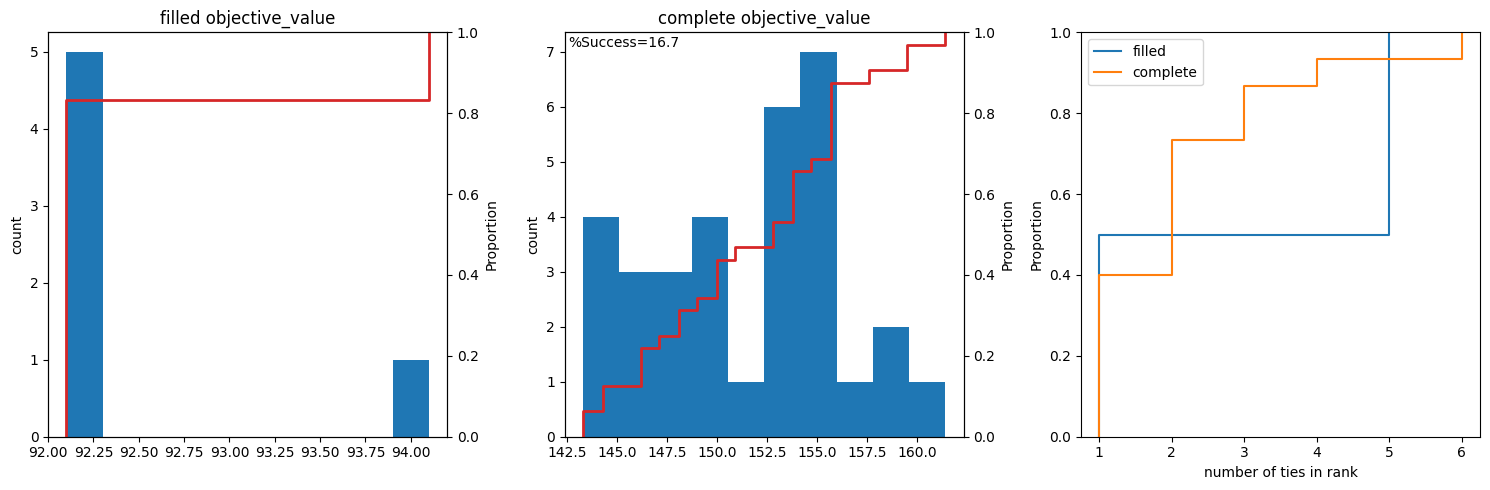

In [29]:
objective_distributions_plot(df_filled_results, df_results)

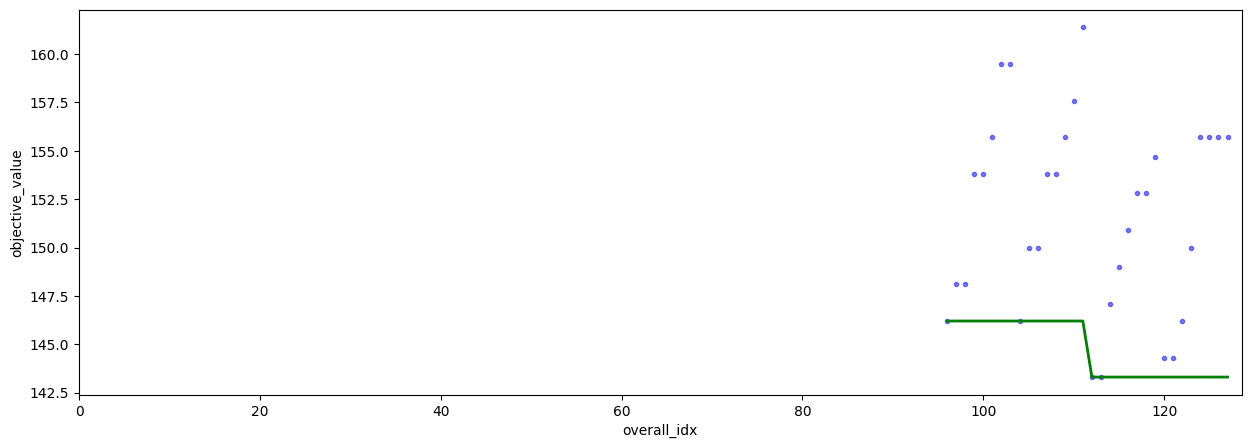

In [35]:
overall_progress_plot(df_filled_results, df_results)

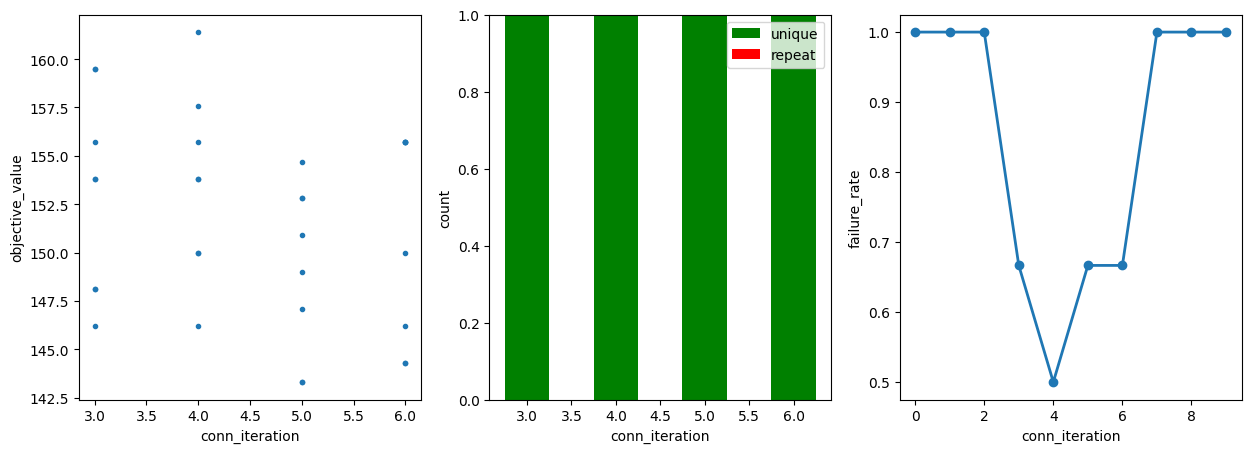

In [42]:
connector_iterations_plot(df_filled_results, df_results)

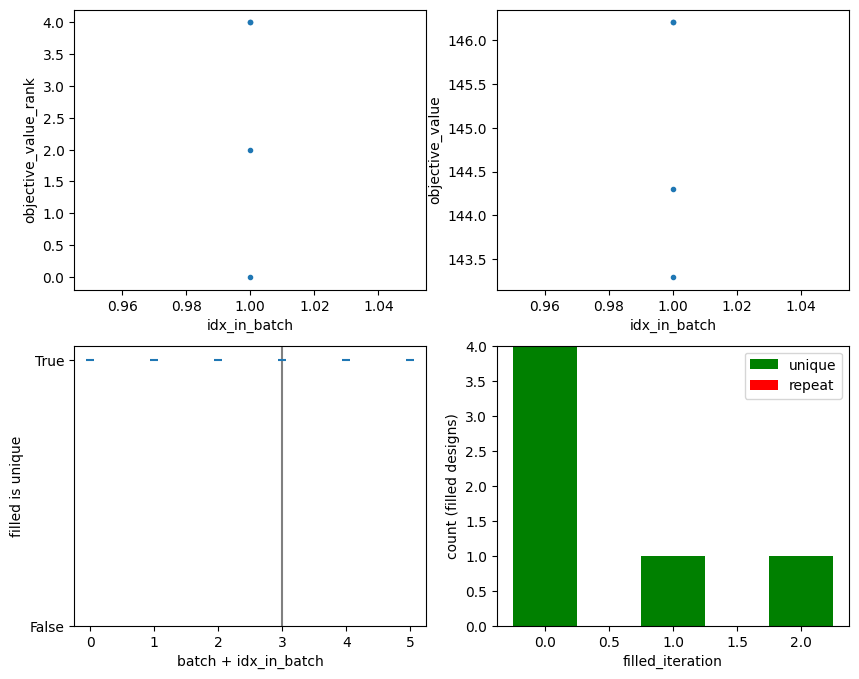

In [44]:
batch_plot(df_filled_results, df_results)

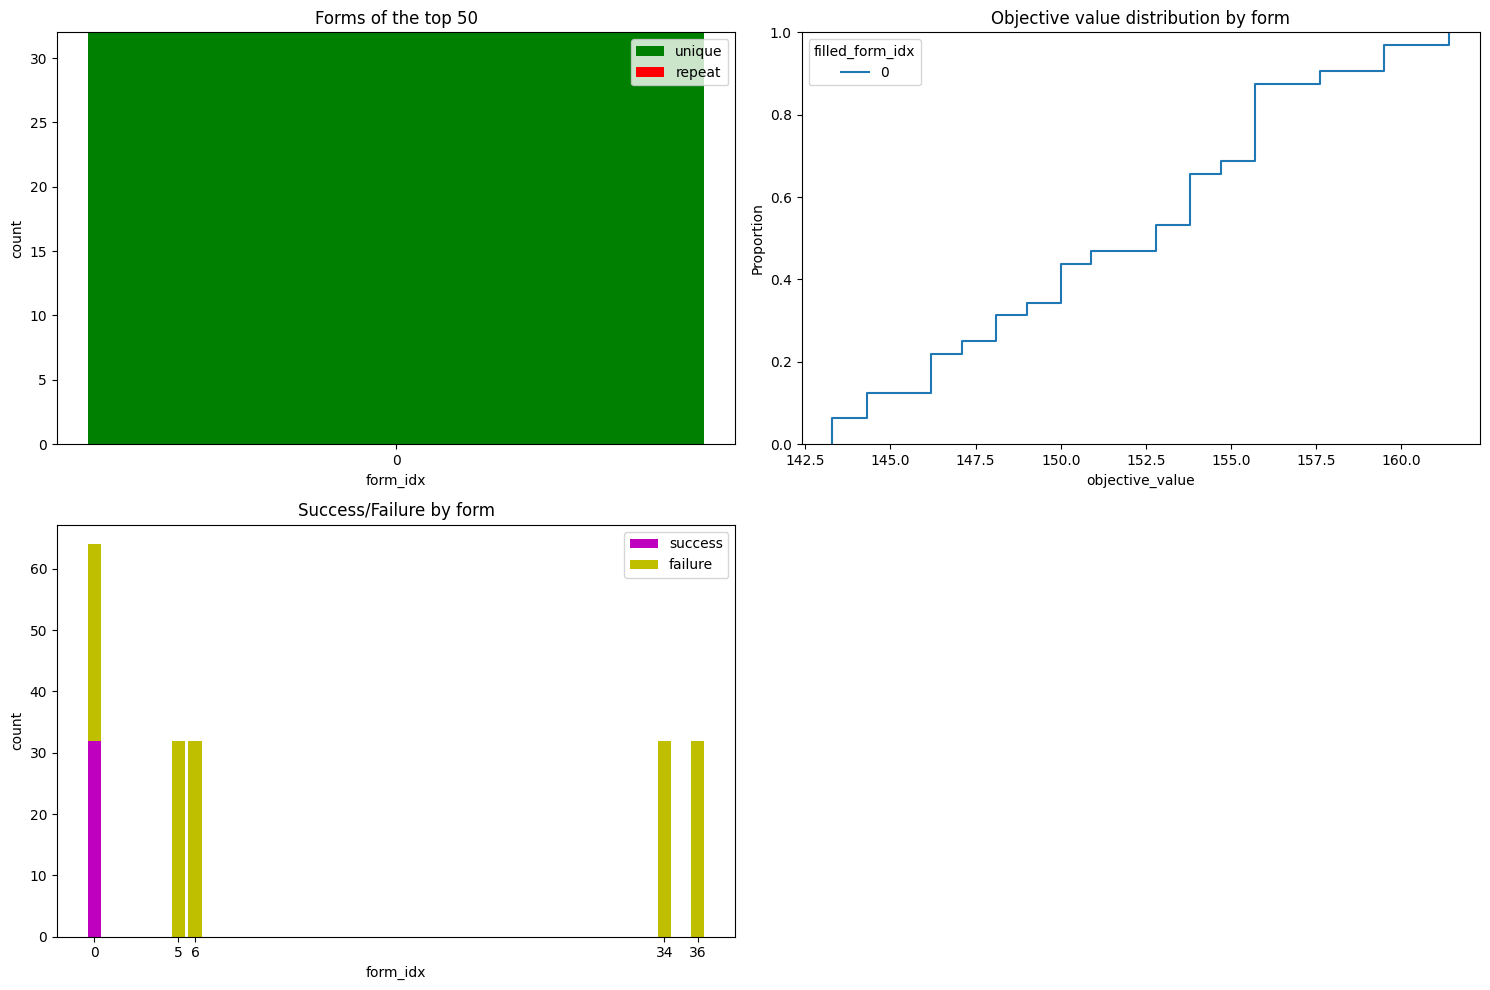

In [64]:
forms_plot(df_filled_results, df_results)